Import کتابخانه‌های مورد نیاز

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")

بارگذاری و خواندن دیتاست

In [2]:
df = pd.read_csv('data/train.csv')
print(f"تعداد ردیف‌ها: {df.shape[0]}")
print(f"تعداد ستون‌ها: {df.shape[1]}")
df.head()

تعداد ردیف‌ها: 30471
تعداد ستون‌ها: 292


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


اکتشاف کامل دیتاست (EDA)

<class 'pandas.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), str(16)
memory usage: 67.9 MB


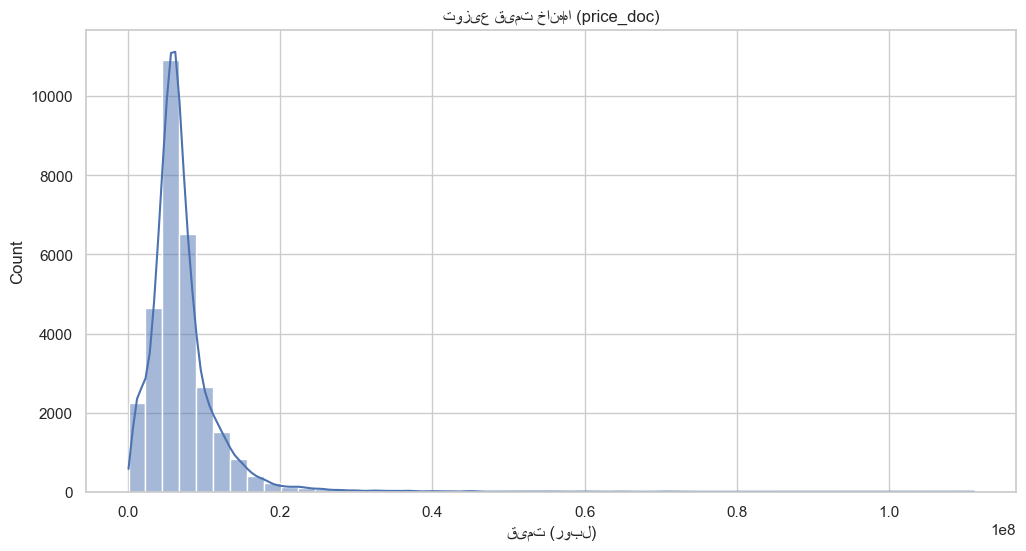

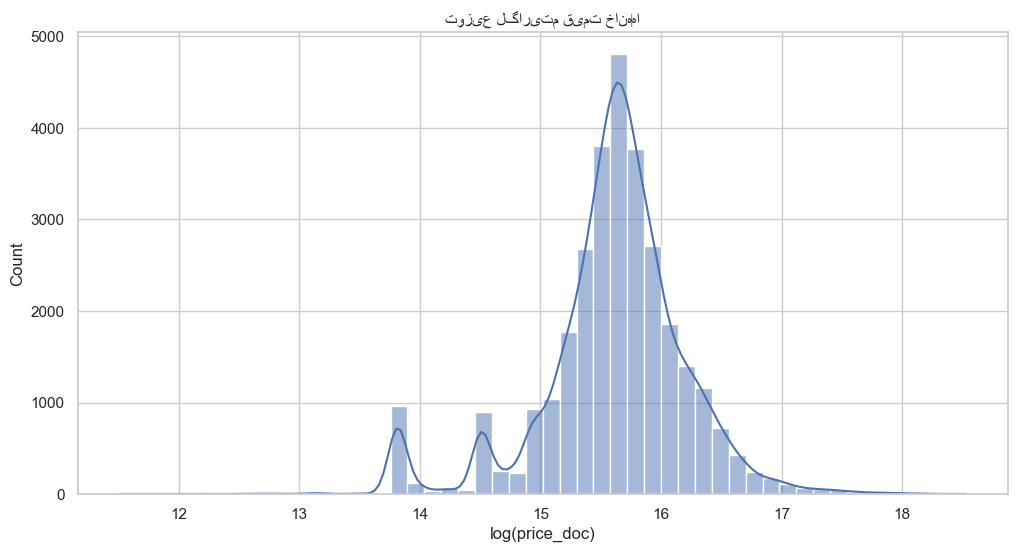

In [3]:
# اطلاعات کلی
df.info()

# آمار توصیفی
df.describe()

# توزیع هدف (price_doc)
plt.figure(figsize=(12, 6))
sns.histplot(df['price_doc'], kde=True, bins=50)
plt.title('توزیع قیمت خانه‌ها (price_doc)')
plt.xlabel('قیمت (روبل)')
plt.show()

# لگاریتم قیمت برای دیدن بهتر توزیع (چون داده‌ها skewed هستند)
df['log_price'] = np.log1p(df['price_doc'])
plt.figure(figsize=(12, 6))
sns.histplot(df['log_price'], kde=True, bins=50)
plt.title('توزیع لگاریتم قیمت خانه‌ها')
plt.xlabel('log(price_doc)')
plt.show()

شناسایی Missing Values

ستون‌های دارای داده گمشده:
                                      تعداد_داده_گمشده  درصد_گمشده
hospital_beds_raion                              14441   47.392603
build_year                                       13605   44.649011
state                                            13559   44.498047
cafe_sum_500_min_price_avg                       13281   43.585704
cafe_sum_500_max_price_avg                       13281   43.585704
cafe_avg_price_500                               13281   43.585704
kitch_sq                                          9572   31.413475
max_floor                                         9572   31.413475
num_room                                          9572   31.413475
material                                          9572   31.413475
preschool_quota                                   6688   21.948738
school_quota                                      6685   21.938893
cafe_sum_1000_min_price_avg                       6524   21.410521
cafe_avg_price_1000                

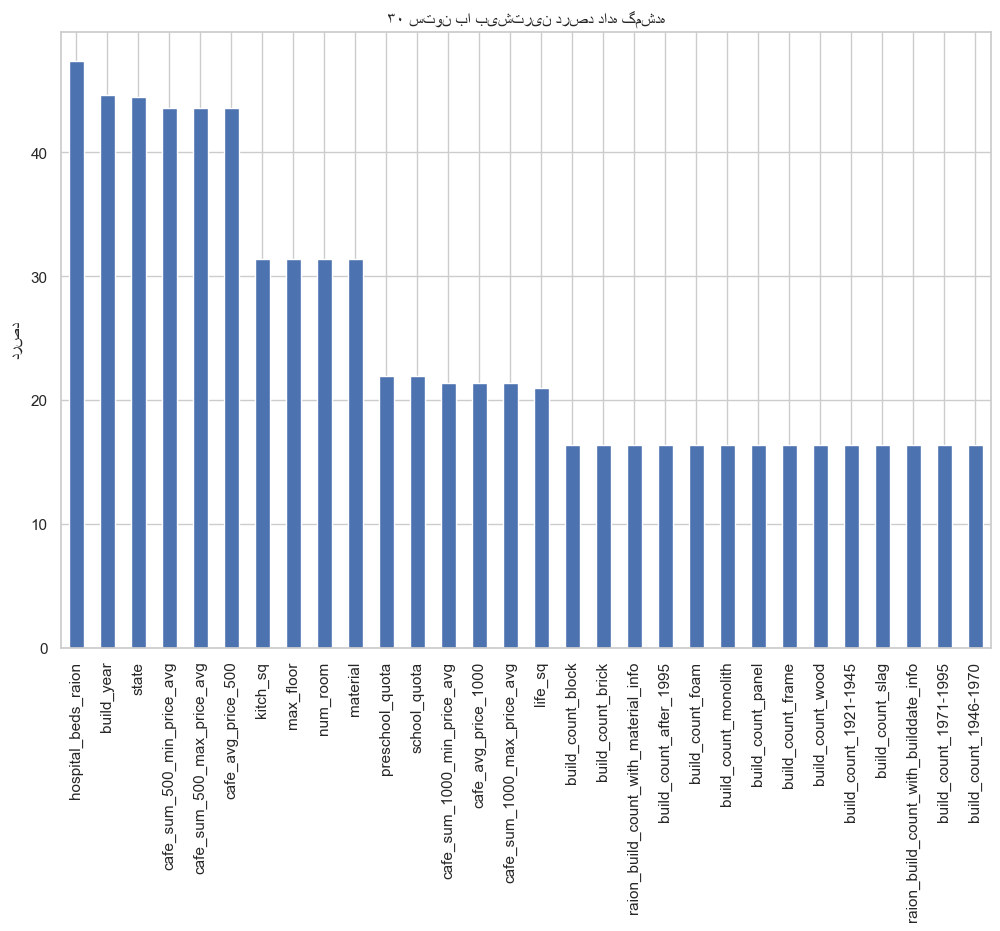

In [4]:
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df)) * 100
missing_df = pd.DataFrame({
    'تعداد_داده_گمشده': missing_count,
    'درصد_گمشده': missing_percent
})
missing_df = missing_df[missing_df['تعداد_داده_گمشده'] > 0].sort_values('درصد_گمشده', ascending=False)

print("ستون‌های دارای داده گمشده:")
print(missing_df.head(20))

# نمودار درصد داده‌های گمشده
plt.figure(figsize=(12, 8))
missing_df['درصد_گمشده'].head(30).plot(kind='bar')
plt.title('۳۰ ستون با بیشترین درصد داده گمشده')
plt.ylabel('درصد')
plt.show()

ترسیم نمودارهای مختلف برای درک بهتر داده‌ها

۱۰ ویژگی با بیشترین همبستگی با قیمت:
log_price           0.829761
num_room            0.476337
full_sq             0.341840
sport_count_5000    0.294864
sport_count_3000    0.290651
trc_count_5000      0.289371
sport_count_2000    0.278056
office_sqm_5000     0.269977
trc_sqm_5000        0.268072
sport_count_1500    0.258376
Name: price_doc, dtype: float64


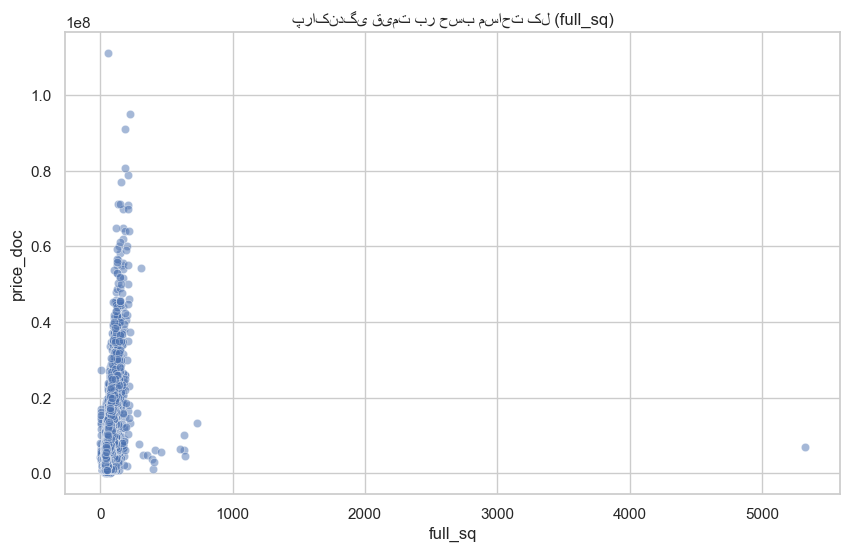

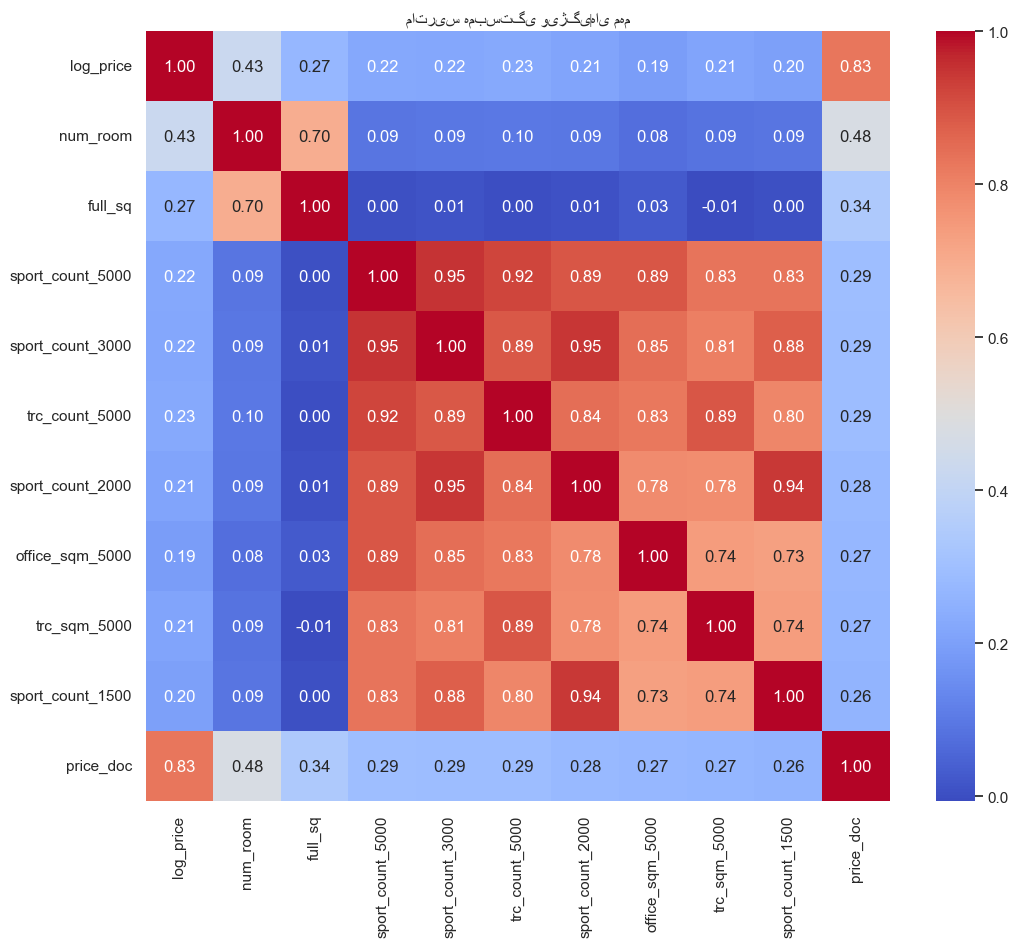

In [5]:
# همبستگی ویژگی‌های عددی با قیمت
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()

# ۱۰ ویژگی با بیشترین همبستگی با price_doc
top_corr = corr_matrix['price_doc'].sort_values(ascending=False)[1:11]
print("۱۰ ویژگی با بیشترین همبستگی با قیمت:")
print(top_corr)

# نمودار پراکندگی برای مهم‌ترین ویژگی (معمولاً full_sq)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='full_sq', y='price_doc', data=df, alpha=0.5)
plt.title('پراکندگی قیمت بر حسب مساحت کل (full_sq)')
plt.show()

# همبستگی بالا برای چند ویژگی مهم
top_features = top_corr.index.tolist() + ['price_doc']
plt.figure(figsize=(12, 10))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('ماتریس همبستگی ویژگی‌های مهم')
plt.show()

پیش‌پردازش، آموزش مدل رگرسیون خطی چندمتغیره و ارزیابی

In [6]:
# انتخاب ویژگی‌های عددی
X = df.select_dtypes(include=['int64', 'float64']).drop(['id', 'price_doc'], axis=1, errors='ignore')
y = df['price_doc']

print(f"تعداد ویژگی‌های عددی استفاده‌شده: {X.shape[1]}")

# پر کردن داده‌های گمشده با میانه (بهتر از میانگین برای داده‌های skewed)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# آموزش مدل رگرسیون خطی
model = LinearRegression()
model.fit(X_train, y_train)

# پیش‌بینی
y_pred = model.predict(X_test)

# معیارهای ارزیابی
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nنتایج مدل رگرسیون خطی (روی مقیاس اصلی قیمت):")
print(f"MSE:  {mse:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"MAE:  {mae:,.0f}")
print(f"R² Score: {r2:.4f}")

تعداد ویژگی‌های عددی استفاده‌شده: 275

نتایج مدل رگرسیون خطی (روی مقیاس اصلی قیمت):
MSE:  5,089,732,448,897
RMSE: 2,256,044
MAE:  1,098,674
R² Score: 0.7622
